In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi

from air_traffic.visual import draw_map, get_hkia_coordinates, \
    voronoi_finite_polygons_2d
from air_traffic.io import read_trajectories, read_trajectories_range

plt.rcParams['figure.dpi'] = 120

## 1 - Distribution of Trajectories

Our dataset contains historical trajectory data for flights that arrived at the Hong Kong International Airport (HKIA).

Below are some example flight trajectories. We can see that the flights follow very regular routes. To visualize these flight routes, the second figure below superimposes the trajectories from a 10-day period. 

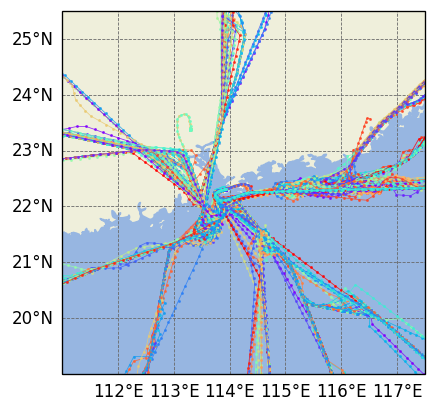

In [3]:
data = read_trajectories("../data/cleaned", "2017-01-01")
fig, ax = draw_map()

ncolor = 25
cmap = plt.cm.get_cmap("rainbow", ncolor)

for i, df in enumerate(data):

    lat = df["latitude"].to_numpy()
    lon = df["longitude"].to_numpy()
    c = cmap(i % ncolor)

    ax.plot(lon, lat, transform=ccrs.Geodetic(),
            marker=".", ms=1.5, linewidth=0.5, alpha=0.8, color=c)

plt.show()

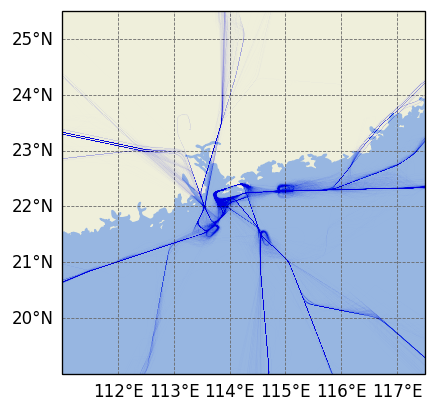

In [4]:
datasets = read_trajectories_range("../data/cleaned", "2017-01-01", "2017-01-10")
fig, ax = draw_map()

for data in datasets:
    for i, df in enumerate(data):

        lat = df["latitude"].to_numpy()
        lon = df["longitude"].to_numpy()

        ax.plot(lon, lat, transform=ccrs.Geodetic(),
                linewidth=0.1, alpha=0.015, color="blue")

plt.show()

<br>

Before we go on, I want to briefly comment that there is a lot of data cleaning needed before we can use the data for analysis. For instance, many of the flight trajectories do not even end near the airport --- if we plot the endpoints of the trajectories, we see that they are all over the place.

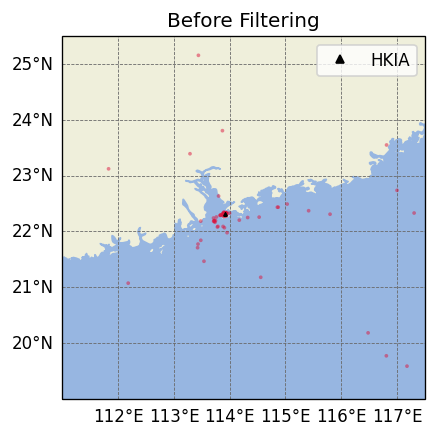

In [5]:
# Compute all the entry and end point
datasets = read_trajectories_range("../data/extracted", "2017-01-01", "2017-01-31")
hklat, hklon = get_hkia_coordinates()

fig, ax = draw_map()

for data in datasets:
    for i, df in enumerate(data):

        lat = df["latitude"].iloc[-1]
        lon = df["longitude"].iloc[-1]

        ax.scatter(lon, lat, s=5, c="crimson", marker="o",
                   alpha=0.5, edgecolors="none")

ax.set_title("Before Filtering")

ax.plot([hklon], [hklat], "^", ms=2, color="black", linestyle="none")
ax.plot([], [], "^", ms=5, color="black", linestyle="none", label="HKIA")
ax.legend(loc="upper right")

plt.show()

After all the cleaning work, we keep only the flights that land near the airport. See `pipeline/2_filter.py` to find out what exactly was thrown away, or see Section 4.2.1 of my [thesis](https://drive.google.com/file/d/1wgr3l9psxnW8qiUr-FL-vXN2wRbjcxAC/view?usp=sharing) for a full summary.

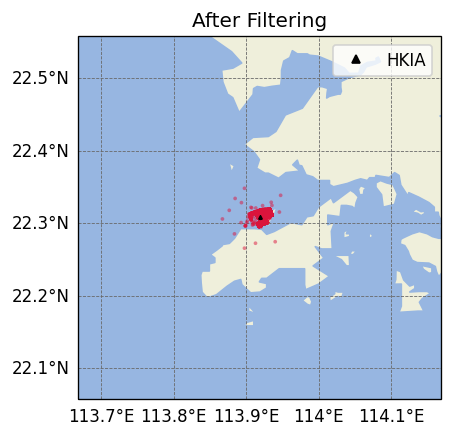

In [6]:
# Compute all the entry and end point
datasets = read_trajectories_range("../data/cleaned", "2017-01-01", "2017-01-31")


fig, ax = draw_map(boundary=[hklon-0.25, hklon+0.25, hklat-0.25, hklat+0.25])

for data in datasets:
    for i, df in enumerate(data):

        lat = df["latitude"].iloc[-1]
        lon = df["longitude"].iloc[-1]

        ax.scatter(lon, lat, s=5, c="crimson", marker="o",
                   alpha=0.5, edgecolors="none")


ax.set_title("After Filtering")
ax.plot([hklon], [hklat], "^", ms=2, color="black", linestyle="none")
ax.plot([], [], "^", ms=5, color="black", linestyle="none", label="HKIA")
ax.legend(loc="upper right")


plt.show()

<br>

## 2 - Clustering of Entry Direction

As we have already seen, flights come in the Hong Kong area following very specific routes. So once we standardize our analysis to consider flights at the same starting distance (here we arbitrarily chose this distance to be 145-165 km; a range is needed because the data points are discrete), we naturally see the flights come in from very specific directions. Here we perform a k-mean cluster to group the flight from the same direction together; this is important because the different directional groups should have different characteristics as they follow their flight routes.


In [7]:
df = pd.read_csv("../data/results/stat_fixed_distance_145-165.csv")

lat, lon = df["lat_i"].to_numpy(), df["lon_i"].to_numpy()
coords = np.column_stack((lon, lat))

kmeans = KMeans(init="random", n_clusters=5,
                n_init=50, max_iter=300)
kmeans.fit(coords)


# Save the clustering result as a new column
df = df.assign(cluster=kmeans.labels_)
df.to_csv("../data/results/stat_fixed_distance_145-165.csv", index=False)

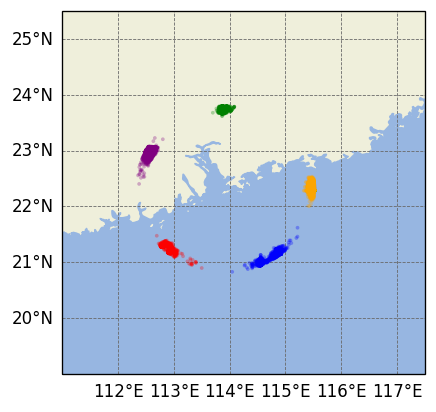

In [8]:
fig, ax = draw_map()

# Give same color to each point in the same cluster
colors = ["blue", "red", "green", "purple", "orange"]
c = [colors[i] for i in kmeans.labels_]

ax.scatter(lon, lat, s=5, c=c, marker="o", alpha=0.3, edgecolors="none")
plt.show()

<br>

## 3 - Significant Points / Waypoints

The airspace is occupied by "significant points" (some of these points are also called "waypoints") that help locate an aircraft. Maybe we can use these significant points to partition the airspace; that would be a handy and natural way to simplify flight trajectories. This partition can be done by drawing the Voronoi cell around each waypoint. But this partition turned out to be not so useful because the significant points are distributed not so uniformly.

In [9]:
df_waypoint = pd.read_csv("../data/misc/significant_points.csv", header=0)
lat = df_waypoint["Lat"].to_numpy()
lon = df_waypoint["Lon"].to_numpy()


# Compute Voronoi cells
vor = Voronoi(list(zip(lon, lat)))
regions, vertices = voronoi_finite_polygons_2d(vor)

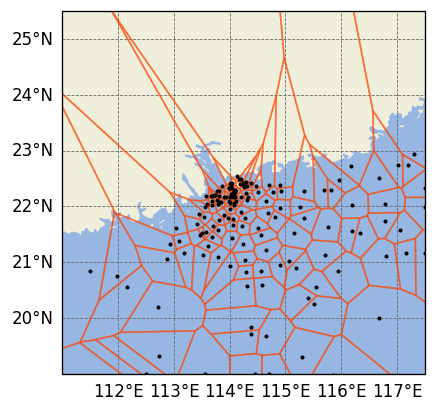

In [10]:
figure, ax = draw_map()

for region in regions:
    polygon = vertices[region]
    ax.fill(*zip(*polygon), color="none", edgecolor="orangered", alpha=0.5)
ax.scatter(lon, lat, s=2, color="black")

plt.show()